# Prevendo o preço de aluguel na cidade de São Paulo

* Queremos entender como é a variação do preço dos aluguéis na cidade a partir de uma base de dados [disponível no Kaggle da Imobiliária Quinto Andar](https://www.kaggle.com/datasets/dantebarros/transformed-data-from-quinto-andars-platform)
    - A previsão do aluguel do imóvel resulta em uma decisão de negócio: decidir em quais imóveis investir e quais imóveis trarão um retorno financeiro mais rápido do investimento.

## Etapas do Projeto

1. [Entendimento e tratamento dos dados](#dados)
2. [Análise Exploratória](#eda)
3. [Tratamento dos Dados](#tratamento)
4. [Definição do modelo](#modelo)
5. [Modelo em produção](#producao)

<a id='dados'></a>
## Entendimento e tratamento dos dados

In [1]:
# Importando a biblioteca Pandas para manipulação da base de dados
import pandas as pd

In [2]:
# Importando a base de dados como um DataFrame
base = pd.read_csv('quinto_andar_transformed_data.csv')

# Visualizando as primeiras linhas do DataFrame
base.head(5)

,url,bairro,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox
0,https://www.quintoandar.com.br/imovel/89332996...,Liberdade,1900.0,424.0,5.0,25.0,38.0,2392.0,57.0,1.0,1.0,1.0,18.0,1.0,0.0,1.0
1,https://www.quintoandar.com.br/imovel/89334069...,Santa Cecília,1190.0,460.0,0.0,16.0,23.0,1689.0,56.0,1.0,1.0,0.0,11.0,1.0,1.0,1.0
2,https://www.quintoandar.com.br/imovel/89333859...,Aclimação,2330.0,450.0,5.0,30.0,46.0,2861.0,48.0,1.0,1.0,1.0,10.0,1.0,0.0,1.0
3,https://www.quintoandar.com.br/imovel/89337065...,Liberdade,1850.0,418.0,6.0,24.0,37.0,2335.0,44.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0
4,https://www.quintoandar.com.br/imovel/89337700...,Vila Guilherme,2200.0,392.0,10.0,28.0,44.0,2674.0,62.0,2.0,2.0,1.0,8.0,1.0,0.0,0.0


* Interpretar o que cada atributo/feature/coluna significa para um dado imóvel é importante para definir quais são nossos objetivos de predições e quais são importantes para o modelo final.

* Para validarmos os dados, é importante entender quais são os tipos/classes de dados armazenados no DataFrame:
    - Podemos utilizar o atributo do Pandas .info()

In [3]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2775 entries, 0 to 2774
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   url              2775 non-null   object 
 1   bairro           2775 non-null   object 
 2   aluguel          2775 non-null   float64
 3   condominio       2768 non-null   float64
 4   iptu             2767 non-null   float64
 5   seguro_incendio  2775 non-null   float64
 6   taxa_serviço     2775 non-null   float64
 7   total            2775 non-null   float64
 8   metragem         2775 non-null   float64
 9   quarto           2775 non-null   float64
 10  banheiro         2775 non-null   float64
 11  vaga_carro       2775 non-null   float64
 12  andar            2775 non-null   float64
 13  aceita_pet       2775 non-null   float64
 14  mobilia          2775 non-null   float64
 15  metro_prox       2775 non-null   float64
dtypes: float64(14), object(2)
memory usage: 347.0+ KB


* O que tiramos do .info()?
    - A *url* e *bairro* são do tipo string, a classe de tipo texto que não é possível de colocar para treinarmos modelos de Machine Learning;
    - Features como *condomínio* e *iptu* possuem valores nulos.

In [4]:
# Somando quantos valores nulos existem em cada coluna, lembrando que o método .isnull() retorna um DataFrame de booleanos, por isso a soma retorna True=1 e False=0
base.isnull().sum()

url                0
bairro             0
aluguel            0
condominio         7
iptu               8
seguro_incendio    0
taxa_serviço       0
total              0
metragem           0
quarto             0
banheiro           0
vaga_carro         0
andar              0
aceita_pet         0
mobilia            0
metro_prox         0
dtype: int64

In [5]:
# Filtrando os imóveis com condomínio nulo
base[base.condominio.isnull()]

,url,bairro,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox
987,https://www.quintoandar.com.br/imovel/89288689...,Bela Vista,2960.0,NaN,125.0,49.0,59.0,3193.0,100.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0
1391,https://www.quintoandar.com.br/imovel/89310205...,Perdizes,5200.0,NaN,1030.0,86.0,104.0,6420.0,220.0,3.0,3.0,1.0,0.0,1.0,0.0,0.0
1527,https://www.quintoandar.com.br/imovel/89310896...,Aclimação,3000.0,NaN,158.0,50.0,60.0,3268.0,90.0,3.0,1.0,1.0,0.0,1.0,0.0,1.0
1801,https://www.quintoandar.com.br/imovel/89284189...,Ipiranga,2600.0,NaN,100.0,43.0,52.0,2795.0,100.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0
2287,https://www.quintoandar.com.br/imovel/89288795...,Ipiranga,1000.0,NaN,80.0,17.0,20.0,1117.0,25.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0
2387,https://www.quintoandar.com.br/imovel/89288796...,Ipiranga,1375.0,NaN,100.0,23.0,27.0,1525.0,50.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2751,https://www.quintoandar.com.br/imovel/89288796...,Ipiranga,1375.0,NaN,100.0,23.0,27.0,1525.0,50.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


* Uma possibilidade é acessar o anúncio pela URL e encontrar o valor do condomínio.

In [6]:
base.url[2287]

'https://www.quintoandar.com.br/imovel/892887955?house_tags=rentPriceDecreased&search_rank=%7B%22sortMode%22%3A%22relevance%22%2C%22searchMode%22%3A%22list%22%2C%22resultsOrigin%22%3A%22search%22%2C%22rank%22%3A929%2C%22personalization%22%3Atrue%7D&search_id=%22d29c9fa4f19011eb8c20e2cf81d20c5e%22&from_route=%22search_results%22'

* Analisando os imóveis no site da Quinto Andar, nota-se que em sua maioria, os imóveis que não possuem condomónio são casas e, então, pode-se substituir este atributo por valores nulos

In [7]:
base.loc[base.condominio.isnull(), 'condominio']

987    NaN
1391   NaN
1527   NaN
1801   NaN
2287   NaN
2387   NaN
2751   NaN
Name: condominio, dtype: float64

In [8]:
base.loc[base.condominio.isnull(), 'condominio'] = 0

In [9]:
base.isnull().sum()

url                0
bairro             0
aluguel            0
condominio         0
iptu               8
seguro_incendio    0
taxa_serviço       0
total              0
metragem           0
quarto             0
banheiro           0
vaga_carro         0
andar              0
aceita_pet         0
mobilia            0
metro_prox         0
dtype: int64

In [10]:
base[base.iptu.isnull()]

,url,bairro,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox
321,https://www.quintoandar.com.br/imovel/89278332...,Jardim Paulista,3530.0,1000.0,NaN,45.0,70.0,4723.0,75.0,1.0,2.0,1.0,10.0,1.0,0.0,1.0
580,https://www.quintoandar.com.br/imovel/89276781...,Aclimação,1500.0,477.0,NaN,20.0,30.0,2027.0,67.0,1.0,1.0,0.0,3.0,0.0,0.0,1.0
732,https://www.quintoandar.com.br/imovel/89277791...,Vila Olímpia,3700.0,0.0,NaN,47.0,74.0,3821.0,60.0,1.0,1.0,1.0,15.0,0.0,0.0,0.0
1348,https://www.quintoandar.com.br/imovel/89277231...,Consolação,2696.0,1033.0,NaN,35.0,53.0,3882.0,88.0,3.0,2.0,1.0,4.0,1.0,1.0,1.0
1486,https://www.quintoandar.com.br/imovel/89279154...,Jardim Paulista,6750.0,1400.0,NaN,86.0,135.0,8371.0,90.0,1.0,2.0,2.0,4.0,0.0,1.0,1.0
1709,https://www.quintoandar.com.br/imovel/89281155...,Aclimação,3000.0,1100.0,NaN,39.0,60.0,4199.0,100.0,3.0,2.0,2.0,2.0,1.0,0.0,1.0
2209,https://www.quintoandar.com.br/imovel/89278332...,Jardim Paulista,3530.0,1000.0,NaN,45.0,70.0,4723.0,75.0,1.0,2.0,1.0,10.0,1.0,0.0,1.0
2659,https://www.quintoandar.com.br/imovel/89279454...,Bela Vista,906.0,267.0,NaN,12.0,18.0,1203.0,27.0,1.0,1.0,0.0,14.0,0.0,0.0,1.0


* Aqui, podemos tentar encontrar qual é o valor médio do IPTU para estas casas/apartamentos nos bairros em que estão localizados. Mas como temos apenas 8 linhas com IPTU faltante, exclui-las não fará uma grande diferença no modelo preditivo.

In [11]:
base = base.dropna(axis=0) # Removendo linhas com valores nulos

In [12]:
base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2767 entries, 0 to 2774
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   url              2767 non-null   object 
 1   bairro           2767 non-null   object 
 2   aluguel          2767 non-null   float64
 3   condominio       2767 non-null   float64
 4   iptu             2767 non-null   float64
 5   seguro_incendio  2767 non-null   float64
 6   taxa_serviço     2767 non-null   float64
 7   total            2767 non-null   float64
 8   metragem         2767 non-null   float64
 9   quarto           2767 non-null   float64
 10  banheiro         2767 non-null   float64
 11  vaga_carro       2767 non-null   float64
 12  andar            2767 non-null   float64
 13  aceita_pet       2767 non-null   float64
 14  mobilia          2767 non-null   float64
 15  metro_prox       2767 non-null   float64
dtypes: float64(14), object(2)
memory usage: 367.5+ KB


In [13]:
base.isnull().sum()

url                0
bairro             0
aluguel            0
condominio         0
iptu               0
seguro_incendio    0
taxa_serviço       0
total              0
metragem           0
quarto             0
banheiro           0
vaga_carro         0
andar              0
aceita_pet         0
mobilia            0
metro_prox         0
dtype: int64

* Para a análise do modelo, o URL não servirá de nada a partir de agora

In [14]:
base = base.drop('url', axis=1)

In [15]:
base.head(5)

,bairro,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox
0,Liberdade,1900.0,424.0,5.0,25.0,38.0,2392.0,57.0,1.0,1.0,1.0,18.0,1.0,0.0,1.0
1,Santa Cecília,1190.0,460.0,0.0,16.0,23.0,1689.0,56.0,1.0,1.0,0.0,11.0,1.0,1.0,1.0
2,Aclimação,2330.0,450.0,5.0,30.0,46.0,2861.0,48.0,1.0,1.0,1.0,10.0,1.0,0.0,1.0
3,Liberdade,1850.0,418.0,6.0,24.0,37.0,2335.0,44.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0
4,Vila Guilherme,2200.0,392.0,10.0,28.0,44.0,2674.0,62.0,2.0,2.0,1.0,8.0,1.0,0.0,0.0


<a id='eda'></a>
## Análise Exploratória de Dados

* Essa etapa consiste em entender a estatística dos nossos dados para podermos aprofundar a análise.

* Como nossa base de dados está em um DataFrame do Pandas, uma boa possibilidade é utilizar o .describe()

In [16]:
base.describe()

,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox
count,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000,2767.000000
mean,2276.430430,596.070473,283.561980,29.923021,45.325985,3232.463679,63.759668,1.593784,1.398265,0.627033,5.924828,0.775208,0.202024,0.733647
std,1327.758115,430.433379,9424.657082,17.660109,26.584522,9600.842536,38.680371,0.748924,0.686907,0.674153,5.000881,0.417521,0.401582,0.442131
min,500.000000,0.000000,0.000000,7.000000,10.000000,697.000000,10.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1400.000000,330.000000,0.000000,18.000000,28.000000,1876.000000,40.000000,1.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.000000
50%,1950.000000,520.000000,55.000000,26.000000,39.000000,2615.000000,52.000000,1.000000,1.000000,1.000000,5.000000,1.000000,0.000000,1.000000
75%,2735.000000,800.000000,140.000000,36.000000,54.000000,3751.000000,76.000000,2.000000,2.000000,1.000000,9.000000,1.000000,0.000000,1.000000
max,11250.000000,3300.000000,495800.000000,187.000000,225.000000,499600.000000,587.000000,5.000000,7.000000,6.000000,43.000000,1.000000,1.000000,1.000000


* Aqui, podemos olhar especialmente para a feature Aluguel:
    - Possui um desvio padrão alto, o que significa que há uma grande dispersão dos valores em relação à média. 
    - A mediana, o segundo quartil (50%), é 1950, enquanto o máximo é 11250. Isso significa que metade dos aluguéis estão abaixo da mediana e a outra metade está dispersa até o valor máximo.

In [ ]:
# Contando o número de registros antes e depois da mediana
base[base.aluguel <= base.aluguel.median()].shape[0] # ou base[base.aluguel <= base.aluguel.median()] para mostrar o DataFrame dos registros

1387

In [23]:
base[base.aluguel > base.aluguel.median()].shape[0]

1380

* Nota-se que, o número de registro é praticamente idêntico, porém, a faixa de distribuição de valores acima da mediana é muito alta, o que resulta em um alto desvio padrão.

* Podemos analisar essa distribuição com um Histograma

<Axes: >

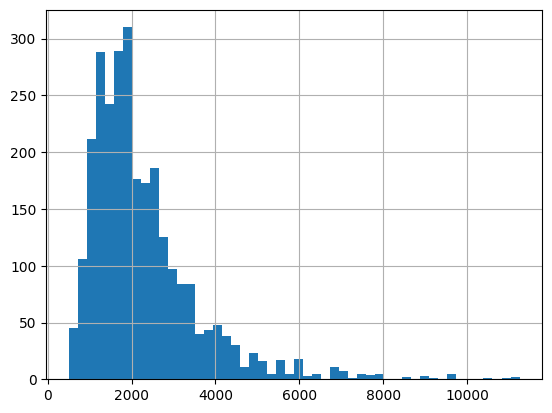

In [30]:
base.aluguel.hist(bins=50)

* Melhorando a visualização dos dados com **Matplotlib**

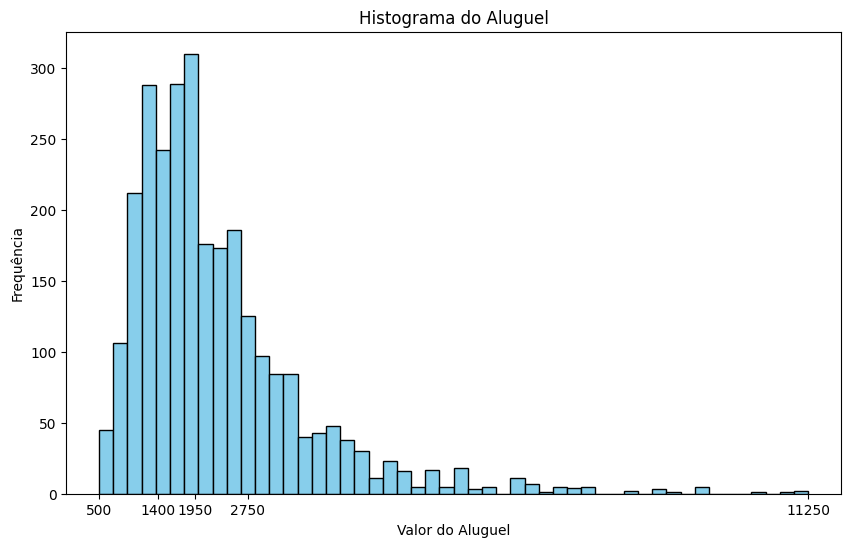

In [32]:
# Plotando o histograma da feature aluguel
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(base.aluguel, bins=50, color='skyblue', edgecolor='black')

ax.set(xlim=(0, base.aluguel.max()+500), xticks=[500, 1400, 1950, 2750, 11250])

plt.title('Histograma do Aluguel')
plt.xlabel('Valor do Aluguel')
plt.ylabel('Frequência')
plt.show()

* Uma outra possibilidade é utilizar o **NumPy** para extrarir a Frequência para cada valor

In [35]:
import numpy as np
np.histogram(base.aluguel, bins=50)

(array([ 45, 106, 212, 288, 242, 289, 310, 176, 173, 186, 125,  97,  84,
         84,  40,  43,  48,  38,  30,  11,  23,  16,   5,  17,   5,  18,
          3,   5,   0,  11,   7,   1,   5,   4,   5,   0,   0,   2,   0,
          3,   1,   0,   5,   0,   0,   0,   1,   0,   1,   2], dtype=int64),
 array([  500.,   715.,   930.,  1145.,  1360.,  1575.,  1790.,  2005.,
         2220.,  2435.,  2650.,  2865.,  3080.,  3295.,  3510.,  3725.,
         3940.,  4155.,  4370.,  4585.,  4800.,  5015.,  5230.,  5445.,
         5660.,  5875.,  6090.,  6305.,  6520.,  6735.,  6950.,  7165.,
         7380.,  7595.,  7810.,  8025.,  8240.,  8455.,  8670.,  8885.,
         9100.,  9315.,  9530.,  9745.,  9960., 10175., 10390., 10605.,
        10820., 11035., 11250.]))

* Uma outra ferramenta importante para entender a estatística dos dados é utilizar o boxplot. Com essa ferramenta, podemos visualizar como os *outliers* podem influenciar na estatística do nosso modelo

<Axes: >

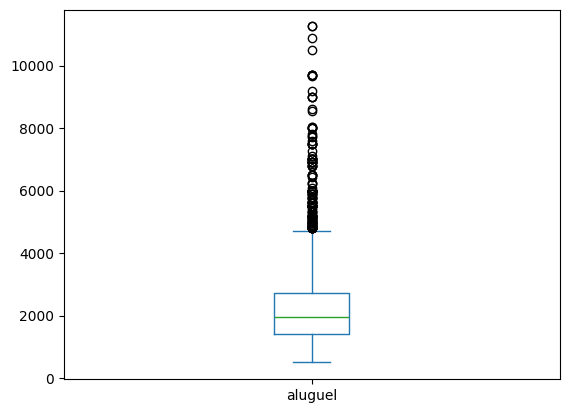

In [37]:
base.aluguel.plot.box()

* A dispersão dos dados após o quarto quartil mostra que há muitos dados como possíveis outliers, o que pode tornar nosso modelo preditivo instável.

* Entender o *por quê* estes imóveis possuem aluguéis mais caros pode ser uma boa forma de entender a estrutura dos dados e quais features aumentam o aluguel.

In [38]:
base.sort_values(by='aluguel', ascending=False).head(10)

,bairro,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox
235,Vila Nova Conceição,11250.0,0.0,584.0,187.0,225.0,12250.0,300.0,4.0,4.0,3.0,0.0,1.0,0.0,0.0
2305,Vila Nova Conceição,11250.0,0.0,584.0,187.0,225.0,12250.0,300.0,4.0,4.0,3.0,0.0,1.0,0.0,0.0
1581,Jardim Paulista,10870.0,2008.0,575.0,138.0,217.0,13810.0,190.0,3.0,4.0,1.0,1.0,1.0,0.0,1.0
762,Paraíso,10500.0,2425.0,42.0,134.0,210.0,13310.0,200.0,3.0,5.0,2.0,8.0,1.0,1.0,1.0
2723,Jardim Paulista,9700.0,2300.0,416.0,123.0,194.0,12730.0,178.0,3.0,3.0,1.0,2.0,1.0,0.0,0.0
1402,Jardim Paulista,9700.0,2300.0,416.0,123.0,194.0,12730.0,178.0,3.0,3.0,1.0,2.0,1.0,0.0,0.0
255,Jardim Paulista,9690.0,1900.0,1000.0,123.0,193.0,12910.0,151.0,3.0,5.0,3.0,5.0,1.0,0.0,1.0
2311,Jardim Paulista,9690.0,1900.0,1000.0,123.0,193.0,12910.0,151.0,3.0,5.0,3.0,5.0,1.0,0.0,1.0
1629,Jardim Paulista,9660.0,1300.0,333.0,123.0,193.0,11610.0,130.0,2.0,2.0,1.0,5.0,1.0,0.0,1.0
387,Itaim Bibi,9200.0,2380.0,694.0,117.0,184.0,12580.0,210.0,4.0,4.0,2.0,11.0,1.0,0.0,0.0


* Existem muitos valores duplicados na base de dados

In [39]:
base[base.duplicated()]

,bairro,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox
77,Barra Funda,1060.0,287.0,0.0,14.0,21.0,1382.0,50.0,1.0,1.0,0.0,2.0,1.0,0.0,1.0
176,Belém,1200.0,200.0,20.0,20.0,24.0,1464.0,30.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
250,Belém,1200.0,200.0,20.0,20.0,24.0,1464.0,30.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
267,Paraíso,3400.0,1372.0,360.0,44.0,68.0,5244.0,147.0,3.0,3.0,1.0,4.0,1.0,0.0,1.0
306,Perdizes,2150.0,0.0,0.0,28.0,43.0,2221.0,72.0,1.0,2.0,0.0,3.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2767,Vila Nova Conceição,3090.0,900.0,184.0,40.0,61.0,4275.0,85.0,2.0,2.0,1.0,12.0,1.0,0.0,0.0
2770,Aclimação,2200.0,0.0,72.0,37.0,44.0,2353.0,90.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0
2771,Santa Cecília,1120.0,280.0,0.0,15.0,22.0,1437.0,32.0,1.0,1.0,0.0,7.0,1.0,0.0,1.0
2773,Aclimação,1100.0,308.0,16.0,14.0,22.0,1460.0,30.0,1.0,1.0,0.0,7.0,1.0,0.0,1.0


In [40]:
base = base.drop_duplicates(keep='last')

In [41]:
base.sort_values(by='aluguel', ascending=False).head(10)

,bairro,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox
2305,Vila Nova Conceição,11250.0,0.0,584.0,187.0,225.0,12250.0,300.0,4.0,4.0,3.0,0.0,1.0,0.0,0.0
1581,Jardim Paulista,10870.0,2008.0,575.0,138.0,217.0,13810.0,190.0,3.0,4.0,1.0,1.0,1.0,0.0,1.0
762,Paraíso,10500.0,2425.0,42.0,134.0,210.0,13310.0,200.0,3.0,5.0,2.0,8.0,1.0,1.0,1.0
2723,Jardim Paulista,9700.0,2300.0,416.0,123.0,194.0,12730.0,178.0,3.0,3.0,1.0,2.0,1.0,0.0,0.0
2311,Jardim Paulista,9690.0,1900.0,1000.0,123.0,193.0,12910.0,151.0,3.0,5.0,3.0,5.0,1.0,0.0,1.0
1629,Jardim Paulista,9660.0,1300.0,333.0,123.0,193.0,11610.0,130.0,2.0,2.0,1.0,5.0,1.0,0.0,1.0
387,Itaim Bibi,9200.0,2380.0,694.0,117.0,184.0,12580.0,210.0,4.0,4.0,2.0,11.0,1.0,0.0,0.0
1505,Jardim Paulista,9000.0,2480.0,496.0,115.0,180.0,12270.0,160.0,3.0,4.0,1.0,7.0,1.0,0.0,1.0
2047,Vila Olímpia,8999.0,2300.0,616.0,115.0,179.0,12210.0,128.0,3.0,3.0,2.0,2.0,1.0,0.0,0.0
680,Jardim Paulista,8990.0,1362.0,352.0,114.0,179.0,11000.0,140.0,2.0,3.0,1.0,19.0,1.0,0.0,1.0


In [43]:
# Comprovando que os registros duplicados foram removidos
base.shape

(2117, 15)

* Agora que os registros duplicados foram removidos, podemos entender a correlação entre a feature aluguel e as demais features que podem resultar no aumento dele

<Axes: xlabel='metragem', ylabel='aluguel'>

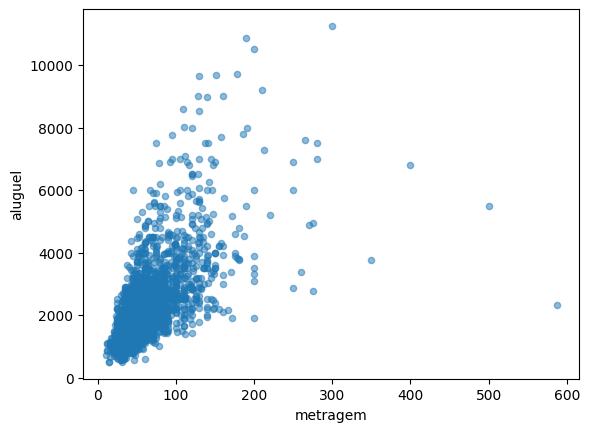

In [50]:
# Qual a relação entre metragem e aluguel?
base.plot.scatter(x='metragem', y='aluguel', alpha=0.5)

<Axes: xlabel='quarto', ylabel='aluguel'>

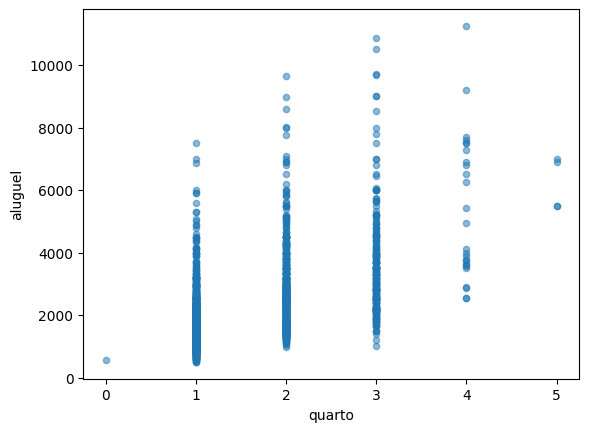

In [53]:
# Relação entre quantidade de quartos e aluguel
base.plot.scatter(x='quarto', y='aluguel', alpha=0.5)

* Podemos perceber que o aumento da metragem influencia no valor do aluguel, mas não é uma relação linear obrigatória. 

* O número de quartos não influencia tanto no valor do aluguel.

* Uma ótima ferramenta de visualização de dispersões e correlações é o **Seaborn**

In [47]:
# Importando o Seaborn
import seaborn as sns

<Axes: xlabel='metro_prox', ylabel='aluguel'>

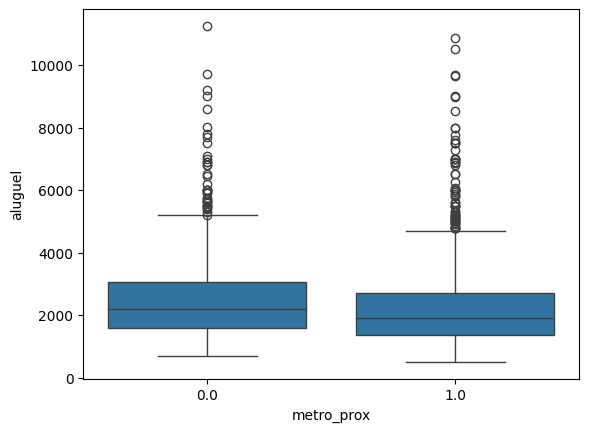

In [ ]:
sns.boxplot(x='metro_prox', y='aluguel', data=base)

<Axes: xlabel='aluguel', ylabel='bairro'>

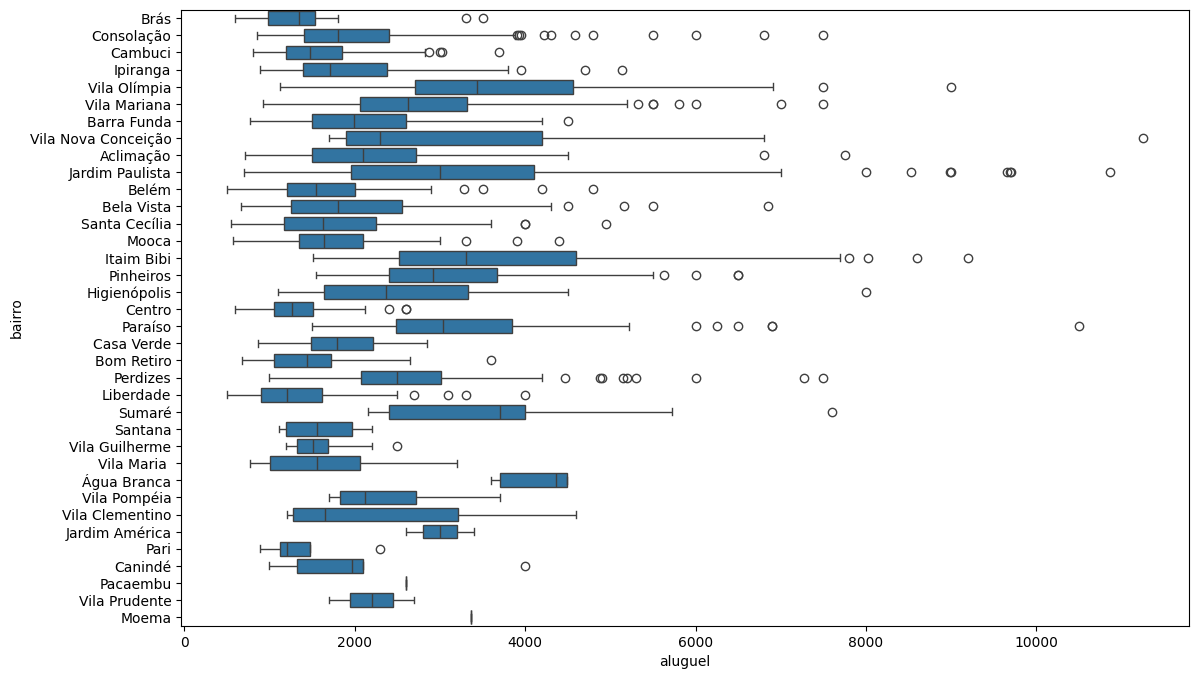

In [56]:
# Relação entre bairro e aluguel
fig, ax = plt.subplots(figsize=(13, 8))

sns.boxplot(x='aluguel', y='bairro', data=base, orient='h')

* Alguns bairros como Vila Olímpia, Itaim Bibi, Jardim Paulista, possuem aluguéis acima da média. Essa dispersão nos da ideia de que, se tiverem um baixo valor de compra, será um bom investimento com alto retorno mensal, já que o aluguel será alto.

In [61]:
base.bairro.value_counts()

bairro
Consolação             271
Jardim Paulista        190
Bela Vista             187
Santa Cecília          178
Pinheiros              117
Vila Mariana           114
Mooca                   99
Itaim Bibi              87
Cambuci                 86
Liberdade               86
Perdizes                84
Centro                  80
Aclimação               75
Paraíso                 59
Ipiranga                55
Barra Funda             53
Bom Retiro              51
Belém                   35
Brás                    29
Vila Olímpia            29
Higienópolis            28
Casa Verde              24
Vila Guilherme          18
Vila Nova Conceição     14
Vila Pompéia            14
Vila Clementino         10
Sumaré                   9
Santana                  8
Canindé                  6
Vila Maria               6
Água Branca              5
Pari                     4
Jardim América           2
Vila Prudente            2
Pacaembu                 1
Moema                    1
Name: count, dtype: i

* Nota-se que, temos diversos Bairros disponível na nossa base de dados, com Bairros aparecem poucas vezes, o que pode gerar problemas no modelo de predição. 

* É possível agrupar Bairros por Regiões, como na base 'bairros.xlsx'

In [98]:
# Importando a base de dados de bairros por região
regioes = pd.read_excel('bairros.xlsx')

In [99]:
# Unindo as bases de dados com merge
base2 = pd.merge(base, regioes, how='left', left_on='bairro', right_on='Bairro')

In [100]:
base2.head(3)

,bairro,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox,Bairro,Região
0,Brás,600.0,450.0,14.0,8.0,12.0,1084.0,31.0,1.0,1.0,0.0,6.0,1.0,0.0,1.0,Brás,Leste
1,Consolação,1790.0,598.0,10.0,23.0,35.0,2456.0,40.0,1.0,1.0,1.0,4.0,1.0,0.0,1.0,Consolação,Centro
2,Cambuci,1550.0,1.0,28.0,26.0,31.0,1636.0,65.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,Cambuci,Centro


* Analisando essa nova base de dados

In [101]:
base2[base2.Região.isnull()]

,bairro,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox,Bairro,Região
234,Vila Maria,3200.0,680.0,68.0,41.0,64.0,4053.0,80.0,2.0,2.0,1.0,7.0,1.0,0.0,0.0,NaN,NaN
820,Vila Maria,850.0,0.0,42.0,15.0,17.0,924.0,40.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN
1262,Vila Maria,1460.0,220.0,106.0,19.0,29.0,1834.0,70.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN
1684,Vila Maria,2200.0,653.0,172.0,28.0,44.0,3097.0,79.0,3.0,2.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN
1845,Vila Maria,1657.0,1050.0,291.0,21.0,33.0,3052.0,110.0,2.0,3.0,2.0,4.0,1.0,0.0,0.0,NaN,NaN
2227,Vila Maria,772.0,0.0,100.0,13.0,15.0,900.0,45.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN


In [102]:
regioes[regioes.Bairro == 'Vila Maria']

,Bairro,Região
58,Vila Maria,Norte


In [103]:
base2.loc[base2.Região.isnull(), 'bairro']

234     Vila Maria 
820     Vila Maria 
1262    Vila Maria 
1684    Vila Maria 
1845    Vila Maria 
2227    Vila Maria 
Name: bairro, dtype: object

* A coluna *bairro* da primeira base de dados importada possui um erro de digitação e, portanto, ao concatenar com a nova base de dados das regiões dos bairros, trouxe dados faltantes (NaN)

* Como o bairro Vila Maria se encontra na região norte, uma maneira de realizar o tratamento dos dados é aplicar a região em que aparecem valores nulos como 'Norte' e o nome do Bairro.

In [104]:
base2.loc[base2.Região.isnull(), 'Região'] = 'Norte'

In [96]:
base2.loc[base2.Região == 'Vila Maria']

,bairro,aluguel,condominio,iptu,seguro_incendio,taxa_serviço,total,metragem,quarto,banheiro,vaga_carro,andar,aceita_pet,mobilia,metro_prox,Bairro,Região
